In [1]:
from helper import get_features, get_csv_as_gpd, get_training_data, get_best_lasso_model, train_xgboost
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt
#https://github.com/slundberg/shap

import warnings
warnings.filterwarnings('ignore')

### Joined city SHAP

In [2]:
cities_fr = ['marseille', 'lyon', 'paris']
cities_de = ['berlin', 'hamburg', 'bremen']

agg_full = pd.DataFrame()

if (len(cities_fr) !=0):
    for city in cities_fr:
        agg = get_training_data(city, 'FR', 1000, 'count', 2015)
        agg_full = agg_full.append(agg)
        
if (len(cities_de) !=0):
    for city in cities_de:
        agg = get_training_data(city, 'DE', 1000, 'count', 2015)
        agg_full = agg_full.append(agg)
    
print(agg_full.shape)
agg_full=agg_full.dropna(axis = 1)
agg_full = agg_full.reset_index(drop = True)
print(agg_full.shape)
agg_full

shape of training data (344, 243)
shape of training data (176, 243)
shape of training data (861, 243)
shape of training data (122, 243)
shape of training data (125, 243)
shape of training data (129, 243)
(1757, 243)
(1757, 243)


,assigned_city,districts_admin_level_11_id,convenience_area_count_1000,camera_surveillance_area_count_1000,tourist_info_area_count_1000,attraction_area_count_1000,pharmacy_area_count_1000,post_box_area_count_1000,bank_area_count_1000,bakery_area_count_1000,...,jewish_min_dist,muslim_min_dist,christian_min_dist,buddhist_min_dist,dist_to_cc,foreign_nationals,unemployment_rate,income_levels,random_noise,geometry
0,marseille,FR-official_id-130020106-admin_level-11,-0.444444,-0.187919,-0.300000,0.0,-0.571429,-0.810811,-0.444444,-0.622222,...,2.841163,2.829058,0.903775,-0.176350,1.454689,-0.684105,-0.521390,1.029202,-0.938123,"POLYGON ((5.54771 43.34452, 5.54753 43.34451, ..."
1,marseille,FR-official_id-130050702-admin_level-11,-0.333333,-0.161074,0.200000,0.0,-0.642857,-0.756757,-0.444444,-0.533333,...,4.198778,4.817203,1.997066,0.033113,2.122303,-0.669459,-0.619313,1.074703,0.579909,"POLYGON ((5.51860 43.28693, 5.51839 43.28692, ..."
2,marseille,FR-official_id-130710105-admin_level-11,-0.333333,-0.080537,-0.200000,0.0,-0.285714,-0.864865,-0.111111,-0.355556,...,3.466202,0.986584,1.253323,-1.716229,1.267491,-0.703629,-0.573965,0.504457,1.792668,"POLYGON ((5.35367 43.37689, 5.35352 43.37659, ..."
3,marseille,FR-official_id-130750102-admin_level-11,-0.444444,-0.107383,-0.400000,0.0,-0.428571,-0.108108,-0.333333,-0.444444,...,1.389558,1.039531,0.382529,0.341271,0.925596,-0.676339,-0.598862,0.612597,1.495818,"POLYGON ((5.47010 43.34248, 5.47001 43.34236, ..."
4,marseille,FR-official_id-130750104-admin_level-11,-0.444444,-0.187919,-0.400000,0.0,-0.571429,-0.324324,-0.444444,-0.444444,...,2.477888,2.057345,2.331364,0.880692,1.379049,-0.691519,-0.454218,0.928744,0.053081,"POLYGON ((5.46373 43.34745, 5.46349 43.34758, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,bremen,DE-official_id-04012000021-admin_level-11,-0.333333,0.000000,-0.470588,0.0,-0.500000,-0.571429,-0.500000,-0.166667,...,0.231711,0.428310,1.972046,1.890189,1.928484,-0.230593,0.339796,0.320310,0.113988,"POLYGON ((8.63110 53.55557, 8.63111 53.55555, ..."
1753,bremen,DE-official_id-04012000022-admin_level-11,0.000000,3.000000,-0.352941,3.0,-0.500000,-0.428571,0.000000,-0.500000,...,-0.741527,0.497816,0.866531,2.180809,2.220471,-0.648528,0.037946,0.463917,-2.063867,"POLYGON ((8.59095 53.59348, 8.59097 53.59336, ..."
1754,bremen,DE-official_id-04012000023-admin_level-11,-0.333333,0.000000,-0.470588,0.0,-1.000000,-0.714286,-0.500000,-0.500000,...,0.570909,0.510213,-0.230222,1.836003,1.873291,-0.565739,0.610655,-0.051318,1.274135,"POLYGON ((8.63762 53.50365, 8.63758 53.50363, ..."
1755,bremen,DE-official_id-04012000024-admin_level-11,0.333333,0.000000,0.000000,0.0,1.000000,0.000000,0.500000,0.333333,...,-0.720531,-0.654242,-0.060436,2.079863,2.117092,0.881500,1.951820,-1.320075,0.559375,"POLYGON ((8.58696 53.56894, 8.58672 53.56694, ..."


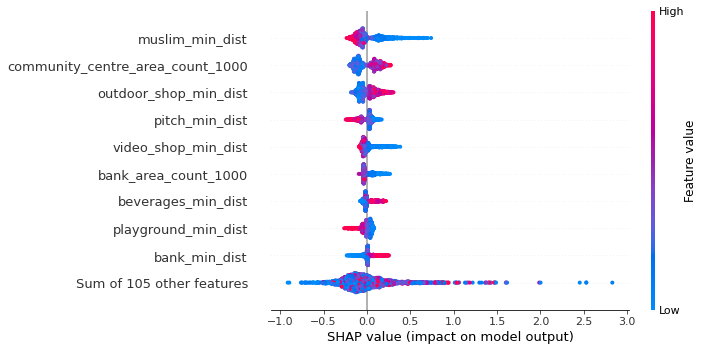

In [6]:
target = 'unemployment_rate'

weights_train = []
for city in agg_full.assigned_city.unique().tolist():
    subset = agg_full[agg_full.assigned_city == city]
    weights = [1 - (len(subset)/len(agg_full))]*len(subset)
    weights_train = weights_train + weights


X_train = agg_full.iloc[:,2:-5]
y_train = agg_full.loc[:,[target]]


# Boosted Lasso predicts
alphas = [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5, 0.6,0.7,0.8,0.9,1,2,3,5,6,7,8,9,10]
lasso = linear_model.Lasso(max_iter = 50000)
parameters = {'alpha':alphas}
clf1 = GridSearchCV(lasso, parameters, scoring = ['neg_mean_squared_error'], refit ='neg_mean_squared_error')
clf1.fit(X_train, y_train, sample_weight= weights_train)

cols_lasso = X_train.loc[:,clf1.best_estimator_.coef_!=0].columns.tolist()
boosted_lasso = train_xgboost(agg_full, target, cols_lasso, 'classifier',learner_type = 'transfer', weights = weights_train)
explainer = shap.Explainer(boosted_lasso.best_estimator_)
shap_values = explainer(X_train[cols_lasso])
shap.plots.beeswarm(shap_values, show = False)
fig = plt.gcf()
fig.savefig('figures/shap_values_unemployment.jpg', dpi = 300, bbox_inches='tight')

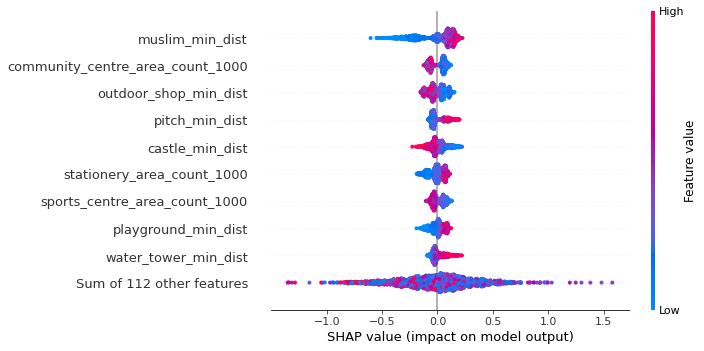

In [7]:
target = 'income_levels'

weights_train = []
for city in agg_full.assigned_city.unique().tolist():
    subset = agg_full[agg_full.assigned_city == city]
    weights = [1 - (len(subset)/len(agg_full))]*len(subset)
    weights_train = weights_train + weights


X_train = agg_full.iloc[:,2:-5]
y_train = agg_full.loc[:,[target]]


# Boosted Lasso predicts
alphas = [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5, 0.6,0.7,0.8,0.9,1,2,3,5,6,7,8,9,10]
lasso = linear_model.Lasso(max_iter = 50000)
parameters = {'alpha':alphas}
clf1 = GridSearchCV(lasso, parameters, scoring = ['neg_mean_squared_error'], refit ='neg_mean_squared_error')
clf1.fit(X_train, y_train, sample_weight= weights_train)

cols_lasso = X_train.loc[:,clf1.best_estimator_.coef_!=0].columns.tolist()
boosted_lasso = train_xgboost(agg_full, target, cols_lasso, 'classifier',learner_type = 'transfer', weights = weights_train)
explainer = shap.Explainer(boosted_lasso.best_estimator_)
shap_values = explainer(X_train[cols_lasso])
shap.plots.beeswarm(shap_values, show = False)
fig = plt.gcf()
fig.savefig('figures/shap_values_income.jpg',  dpi = 300, bbox_inches='tight')

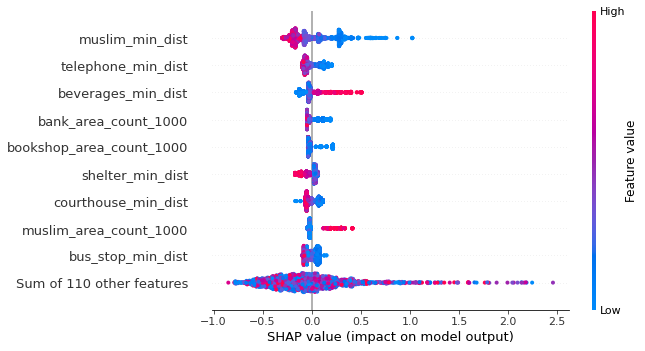

In [8]:
target = 'foreign_nationals'

weights_train = []
for city in agg_full.assigned_city.unique().tolist():
    subset = agg_full[agg_full.assigned_city == city]
    weights = [1 - (len(subset)/len(agg_full))]*len(subset)
    weights_train = weights_train + weights


X_train = agg_full.iloc[:,2:-5]
y_train = agg_full.loc[:,[target]]


# Boosted Lasso predicts
alphas = [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5, 0.6,0.7,0.8,0.9,1,2,3,5,6,7,8,9,10]
lasso = linear_model.Lasso(max_iter = 50000)
parameters = {'alpha':alphas}
clf1 = GridSearchCV(lasso, parameters, scoring = ['neg_mean_squared_error'], refit ='neg_mean_squared_error')
clf1.fit(X_train, y_train, sample_weight= weights_train)

cols_lasso = X_train.loc[:,clf1.best_estimator_.coef_!=0].columns.tolist()
boosted_lasso = train_xgboost(agg_full, target, cols_lasso, 'classifier',learner_type = 'transfer', weights = weights_train)
explainer = shap.Explainer(boosted_lasso.best_estimator_)
shap_values = explainer(X_train[cols_lasso])
shap.plots.beeswarm(shap_values, show = False)
fig = plt.gcf()
fig.savefig('figures/shap_values_foreign_nationals.jpg', dpi = 300, bbox_inches='tight')